In [1]:
import os
os.environ["HADOOP_USER_NAME"] = "spark"
os.environ["SPARK_MAJOR_VERSION"] = "2"
os.environ["SPARK_HOME"] = "/usr/hdp/current/spark2-client"
import findspark
findspark.init()
import pyspark
from pyspark.sql import SparkSession

In [2]:
file_name = "/user/maria_dev/datasets/bank/bank.csv"
spark = SparkSession.builder.appName('ml-bank').getOrCreate()

In [3]:
df = spark.read.csv(file_name, header = True, inferSchema = True)
df.cache()

DataFrame[age: int, job: string, marital: string, education: string, default: string, balance: int, housing: string, loan: string, contact: string, day: int, month: string, duration: int, campaign: int, pdays: int, previous: int, poutcome: string, deposit: string]

In [4]:
import pandas as pd
pd.DataFrame(df.take(5), columns=df.columns).transpose()

,0,1,2,3,4
age,59,56,41,55,54
job,admin.,admin.,technician,services,admin.
marital,married,married,married,married,married
education,secondary,secondary,secondary,secondary,tertiary
default,no,no,no,no,no
balance,2343,45,1270,2476,184
housing,yes,no,yes,yes,no
loan,no,no,no,no,no
contact,unknown,unknown,unknown,unknown,unknown
day,5,5,5,5,5


In [5]:
df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- day: integer (nullable = true)
 |-- month: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- deposit: string (nullable = true)



In [6]:
pd.DataFrame(df.take(11162), columns=df.columns).deposit.value_counts()

no     5873
yes    5289
Name: deposit, dtype: int64

In [7]:
numeric_features = [t[0] for t in df.dtypes if t[1] == 'int']
df.select(numeric_features).describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
age,11162,41.231947679627304,11.913369192215518,18,95
balance,11162,1528.5385235620856,3225.413325946149,-6847,81204
day,11162,15.658036194230425,8.420739541006462,1,31
duration,11162,371.99381831213043,347.12838571630687,2,3881
campaign,11162,2.508421429851281,2.7220771816614824,1,63
pdays,11162,51.33040673714388,108.75828197197717,-1,854
previous,11162,0.8325568894463358,2.292007218670508,0,58


In [9]:
df = df.select('age', 'job', 'marital', 'education', 'default', 'balance', 
               'housing', 'loan', 'contact', 'duration', 'campaign', 
               'pdays', 'previous', 'poutcome', 'deposit')
cols = df.columns
df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- deposit: string (nullable = true)



In [10]:
from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer, VectorAssembler, MinMaxScaler
categoricalColumns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'poutcome']
stages = []
for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    encoder = OneHotEncoderEstimator(inputCols=[stringIndexer.getOutputCol()], 
                                     outputCols=[categoricalCol + "classVec"])
    stages += [stringIndexer, encoder]
label_stringIdx = StringIndexer(inputCol = 'deposit', outputCol = 'label')
stages += [label_stringIdx]
numericCols = ['age', 'balance', 'duration', 'campaign', 'pdays', 'previous']
assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="unscaled_features")
stages += [assembler]
minMaxScaler = MinMaxScaler(inputCol="unscaled_features", outputCol="features")
stages += [minMaxScaler]

In [11]:
df_fr = df 
from pyspark.ml import Pipeline
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(df)
df = pipelineModel.transform(df)
selectedCols = ['label', 'features'] + cols
df = df.select(selectedCols)
df.printSchema()

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- deposit: string (nullable = true)



In [12]:
pd.DataFrame(df.take(5), columns=df.columns).transpose()

,0,1,2,3,4
label,1,1,1,1,1
features,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
age,59,56,41,55,54
job,admin.,admin.,technician,services,admin.
marital,married,married,married,married,married
education,secondary,secondary,secondary,secondary,tertiary
default,no,no,no,no,no
balance,2343,45,1270,2476,184
housing,yes,no,yes,yes,no
loan,no,no,no,no,no


In [13]:
pd.DataFrame(df.take(5), columns=df.columns).transpose()[0].iloc[1]

DenseVector([0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.5325, 0.1044, 0.2681, 0.0, 0.0, 0.0])

In [14]:
train, test = df.randomSplit([0.7, 0.3], seed = 2018)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 7764
Test Dataset Count: 3398


In [20]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10)
lrModel = lr.fit(train)

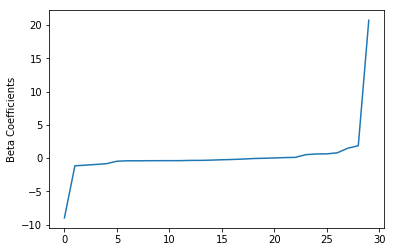

In [22]:
import matplotlib.pyplot as plt
import numpy as np
beta = np.sort(lrModel.coefficients)
plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()

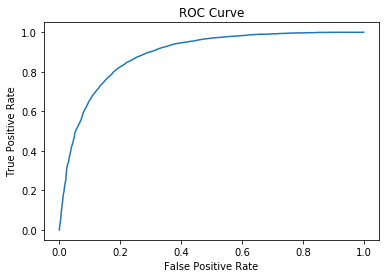

Training set areaUnderROC: 0.88876501475


In [28]:
trainingSummary = lrModel.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

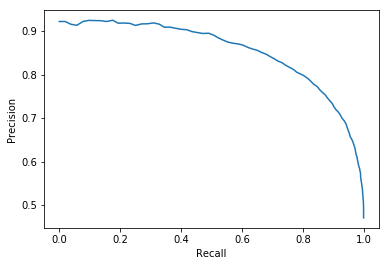

In [24]:
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

In [ ]:
f = trainingSummary.fMeasureByThreshold.toPandas()
plt.plot(f['threshold'],f['F-Measure'])
plt.ylabel('F-Measure')
plt.xlabel('Threshold')
plt.show()

In [25]:
predictions = lrModel.transform(test)
predictions.select('age', 'job', 'label', 'rawPrediction', 'prediction', 'probability').show(10)

+---+---------+-----+--------------------+----------+--------------------+
|age|      job|label|       rawPrediction|prediction|         probability|
+---+---------+-----+--------------------+----------+--------------------+
| 30|  unknown|  0.0|[-0.9474334792972...|       1.0|[0.27940126281791...|
| 41|  unknown|  0.0|[-0.5029294235980...|       1.0|[0.37685249074384...|
| 47|  unknown|  0.0|[2.15481774851860...|       0.0|[0.89611811984280...|
| 48|  unknown|  0.0|[0.85458029443076...|       0.0|[0.70152708022803...|
| 53|  unknown|  0.0|[0.75366558530892...|       0.0|[0.67997688672423...|
| 35|  unknown|  0.0|[0.81567587317272...|       0.0|[0.69331767784691...|
| 46|  unknown|  0.0|[-1.3857310402613...|       1.0|[0.20009014656941...|
| 36|  unknown|  0.0|[2.44373811768842...|       0.0|[0.92010232385901...|
| 49|housemaid|  0.0|[3.00666036135810...|       0.0|[0.95287411433769...|
| 41|housemaid|  0.0|[0.82382298402049...|       0.0|[0.69504725036640...|
+---+---------+-----+----

In [27]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator()
print('Test Area Under ROC', evaluator.evaluate(predictions))

('Test Area Under ROC', 0.8763050573226124)


In [15]:
from pyspark.ml.classification import RandomForestClassifier
rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label')
rfModel = rf.fit(train)
predictions = rfModel.transform(test)
predictions.select('age', 'job', 'label', 'rawPrediction', 'prediction', 'probability').show(10)
stages_fr = stages + [rf]

+---+---------+-----+--------------------+----------+--------------------+
|age|      job|label|       rawPrediction|prediction|         probability|
+---+---------+-----+--------------------+----------+--------------------+
| 30|  unknown|  0.0|[8.36714053225245...|       1.0|[0.41835702661262...|
| 41|  unknown|  0.0|[8.51451651843372...|       1.0|[0.42572582592168...|
| 47|  unknown|  0.0|[16.9347373972501...|       0.0|[0.84673686986250...|
| 48|  unknown|  0.0|[14.8167827612554...|       0.0|[0.74083913806277...|
| 53|  unknown|  0.0|[12.0229311377200...|       0.0|[0.60114655688600...|
| 35|  unknown|  0.0|[11.9137385162446...|       0.0|[0.59568692581223...|
| 46|  unknown|  0.0|[6.74532432409662...|       1.0|[0.33726621620483...|
| 36|  unknown|  0.0|[15.6206768691677...|       0.0|[0.78103384345838...|
| 49|housemaid|  0.0|[17.3405347910785...|       0.0|[0.86702673955392...|
| 41|housemaid|  0.0|[9.06031996427614...|       1.0|[0.45301599821380...|
+---+---------+-----+----

In [17]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.869777862731


In [31]:
from pyspark.ml.classification import GBTClassifier
gbt = GBTClassifier(maxIter=10)
gbtModel = gbt.fit(train)
predictions = gbtModel.transform(test)
predictions.select('age', 'job', 'label', 'rawPrediction', 'prediction', 'probability').show(10)

+---+---------+-----+--------------------+----------+--------------------+
|age|      job|label|       rawPrediction|prediction|         probability|
+---+---------+-----+--------------------+----------+--------------------+
| 30|  unknown|  0.0|[-0.3523318908051...|       1.0|[0.33077901972256...|
| 41|  unknown|  0.0|[-0.2876226058593...|       1.0|[0.36002740266203...|
| 47|  unknown|  0.0|[1.25380719810740...|       0.0|[0.92467389649615...|
| 48|  unknown|  0.0|[1.04652514289295...|       0.0|[0.89022586607696...|
| 53|  unknown|  0.0|[0.12994887538641...|       0.0|[0.56461115651209...|
| 35|  unknown|  0.0|[0.63858476277446...|       0.0|[0.78196758187405...|
| 46|  unknown|  0.0|[-0.5833084425226...|       1.0|[0.23746704250517...|
| 36|  unknown|  0.0|[1.34962822744884...|       0.0|[0.93698275478767...|
| 49|housemaid|  0.0|[1.25614729512872...|       0.0|[0.92499923453217...|
| 41|housemaid|  0.0|[0.42824993223067...|       0.0|[0.70192885737410...|
+---+---------+-----+----

In [32]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.885939655148


In [33]:
print(gbt.explainParams())

cacheNodeIds: If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval. (default: False)
checkpointInterval: set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext. (default: 10)
featuresCol: features column name. (default: features)
labelCol: label column name. (default: label)
lossType: Loss function which GBT tries to minimize (case-insensitive). Supported options: logistic (default: logistic)
maxBins: Max number of bins for discretizing continuous features.  Must be >=2 and >= number of categories for any categorical feature. (default: 32)
maxDepth: Maximum depth of the tree. (>= 0)

In [34]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
paramGrid = (ParamGridBuilder()
             .addGrid(gbt.maxDepth, [2, 4, 6])
             .addGrid(gbt.maxBins, [20, 60])
             .addGrid(gbt.maxIter, [10, 20])
             .build())
cv = CrossValidator(estimator=gbt, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)
# Run cross validations.  This can take about 6 minutes since it is training over 20 trees!
cvModel = cv.fit(train)
predictions = cvModel.transform(test)
evaluator.evaluate(predictions)

0.889133611227512

In [19]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
paramGrid = (ParamGridBuilder()
             .addGrid(rf.maxDepth, [2, 4, 6])
             .addGrid(rf.maxBins, [20, 60])
             .addGrid(rf.impurity, ["entropy"])
             .build())
pipeline_fr = Pipeline(stages = stages_fr)
cv = CrossValidator(estimator=pipeline_fr, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)
# Run cross validations.  This can take about 6 minutes since it is training over 20 trees!
cvModel = cv.fit(df_fr)